<a href="https://colab.research.google.com/github/itsshaliniS/Text_Recognition/blob/main/index.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:

!pip install tensorflow==2.19.0 matplotlib opencv-python pillow numpy scikit-learn tqdm easyocr pytesseract


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 25.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 180.7/180.7 kB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 963.8/963.8 kB 49.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.6/300.6 kB 24.7 MB/s eta 0:00:00


In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from PIL import Image
import torch
from torchvision import transforms
import pandas as pd

print("TensorFlow version:", tf.__version__)
print("PyTorch version:", torch.__version__)

TensorFlow version: 2.19.0
PyTorch version: 2.9.0+cu126


In [ ]:
base_path = "/content/gdrive/MyDrive/text_recognization/iam_words"
words_dir = os.path.join(base_path, "words")
words_txt = os.path.join(base_path, "words.txt")

print("Words Folder:", words_dir)
print("Text File:", words_txt)
print("Folder exists:", os.path.exists(words_dir))
print("Text file exists:", os.path.exists(words_txt))

Words Folder: /content/gdrive/MyDrive/text_recognization/iam_words/words
Text File: /content/gdrive/MyDrive/text_recognization/iam_words/words.txt
Folder exists: True
Text file exists: True


In [ ]:
def load_annotations(words_txt):
    data = []
    with open(words_txt, 'r') as f:
        for line in f:
            if line.startswith('#') or line.strip() == '':
                continue
            parts = line.strip().split(' ')
            if len(parts) >= 9:
                img_id = parts[0]
                label = " ".join(parts[8:])
                data.append((img_id, label))
    return pd.DataFrame(data, columns=['image_id', 'label'])

annotations_df = load_annotations(words_txt)
print(f"Total annotations: {len(annotations_df)}")
print("\nFirst few annotations:")
print(annotations_df.head(10))

Total annotations: 44564

First few annotations:
         image_id       label
0  a01-000u-00-00           A
1  a01-000u-00-01        MOVE
2  a01-000u-00-02          to
3  a01-000u-00-03        stop
4  a01-000u-00-04         Mr.
5  a01-000u-00-05   Gaitskell
6  a01-000u-00-06        from
7  a01-000u-01-00  nominating
8  a01-000u-01-01         any
9  a01-000u-01-02        more


In [ ]:
class IAMWordsDataset:
    def __init__(self, base_path, annotations, transform=None):
        self.base_path = base_path
        self.annotations = annotations.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        img_id = self.annotations.iloc[idx, 0]
        label = self.annotations.iloc[idx, 1]

        # Build image path: words/a01/a01-000u/a01-000u-00.png
        parts = img_id.split('-')
        img_path = os.path.join(
            self.base_path,
            parts[0],
            f"{parts[0]}-{parts[1]}",
            f"{img_id}.png"
        )

        # Read image
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            raise FileNotFoundError(f"Image not found: {img_path}")

        # Convert to RGB
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

        # Apply transforms
        if self.transform:
            img = self.transform(img)

        return img, label

print("Dataset class created successfully!")

Dataset class created successfully!


In [ ]:
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((64, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

print("Transform pipeline created!")


Transform pipeline created!


In [ ]:
train_annotations, val_annotations = train_test_split(
    annotations_df,
    test_size=0.1,
    random_state=42
)

print(f"Training samples: {len(train_annotations)}")
print(f"Validation samples: {len(val_annotations)}")


Training samples: 40107
Validation samples: 4457


Training batches: 1254
Validation batches: 140


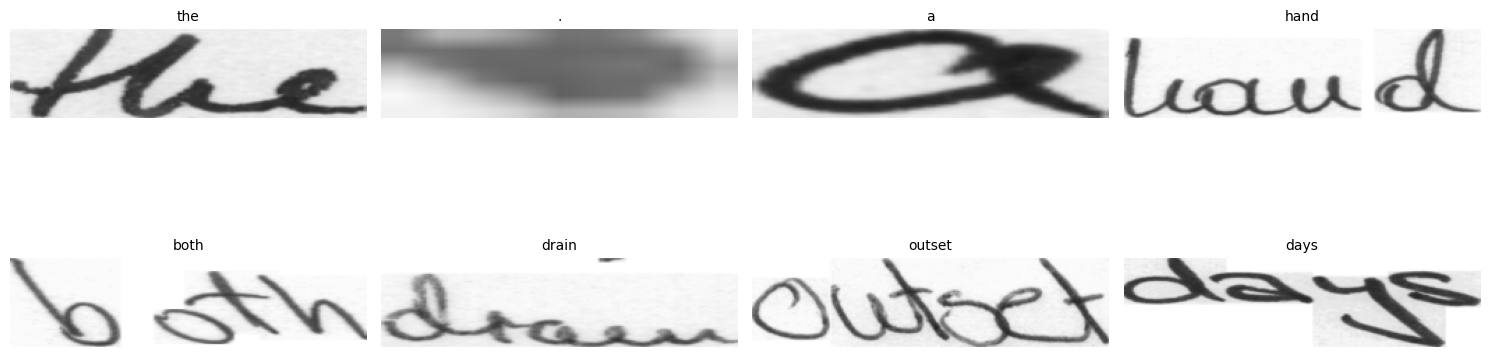

In [ ]:
train_dataset_torch = IAMWordsDataset(
    words_dir,
    train_annotations,
    transform=transform
)
val_dataset_torch = IAMWordsDataset(
    words_dir,
    val_annotations,
    transform=transform
)

train_dataloader = torch.utils.data.DataLoader(
    train_dataset_torch,
    batch_size=32,
    shuffle=True,
    num_workers=2
)

val_dataloader = torch.utils.data.DataLoader(
    val_dataset_torch,
    batch_size=32,
    shuffle=False,
    num_workers=2
)

print(f"Training batches: {len(train_dataloader)}")
print(f"Validation batches: {len(val_dataloader)}")


# ============================================================================
# CELL 10: Visualize Sample Images
# ============================================================================
batch = next(iter(train_dataloader))
images, labels = batch

fig, axes = plt.subplots(2, 4, figsize=(15, 6))
for i, ax in enumerate(axes.flat):
    if i < len(images):
        img = images[i].permute(1, 2, 0).numpy()
        img = (img * 0.5 + 0.5)  # denormalize
        img = np.clip(img, 0, 1)
        ax.imshow(img)
        ax.set_title(labels[i][:20], fontsize=10)
        ax.axis('off')
plt.tight_layout()
plt.show()


In [ ]:
all_chars = set()
for label in annotations_df['label']:
    for char in str(label):
        all_chars.add(char)

char_list = sorted(list(all_chars))
num_classes = len(char_list)

print(f"Number of unique characters: {num_classes}")
print(f"Characters (first 50): {''.join(char_list[:50])}")
if len(char_list) > 50:
    print(f"... and {len(char_list) - 50} more")

Number of unique characters: 77
Characters (first 50):  !"#'()*,-./0123456789:;?ABCDEFGHIJKLMNOPQRSTUVWXY
... and 27 more


In [ ]:
char_to_num = layers.StringLookup(
    vocabulary=char_list,
    mask_token=None
)

num_to_char = layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(),
    mask_token=None,
    invert=True
)

print("Character mapping created!")
print(f"Vocabulary size: {len(char_to_num.get_vocabulary())}")

Character mapping created!
Vocabulary size: 78


In [ ]:
def build_crnn_model(num_classes):
    """
    CRNN: Convolutional Recurrent Neural Network
    - CNN extracts features from images
    - RNN processes sequential features
    - CTC loss for sequence alignment
    """
    input_img = layers.Input(shape=(64, 256, 3), name="image")

    # Convolutional Block 1
    x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(input_img)
    x = layers.MaxPooling2D((2, 2))(x)

    # Convolutional Block 2
    x = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(x)
    x = layers.MaxPooling2D((2, 2))(x)

    # Convolutional Block 3
    x = layers.Conv2D(128, (3, 3), activation="relu", padding="same")(x)
    x = layers.MaxPooling2D((2, 2))(x)

    # Reshape for RNN: (batch, height, width * channels)
    new_shape = ((64 // 8), (256 // 8) * 128)
    x = layers.Reshape(target_shape=new_shape)(x)
    x = layers.Dense(64, activation="relu")(x)

    # Bidirectional LSTM layers
    x = layers.Bidirectional(
        layers.LSTM(128, return_sequences=True, dropout=0.25)
    )(x)
    x = layers.Bidirectional(
        layers.LSTM(64, return_sequences=True, dropout=0.25)
    )(x)

    # Output layer: num_classes + 1 for CTC blank token
    output = layers.Dense(
        num_classes + 1,
        activation="softmax",
        name="dense_output"
    )(x)

    model = keras.Model(inputs=input_img, outputs=output, name="CRNN")
    return model

crnn_model = build_crnn_model(num_classes)
crnn_model.summary()


Model: "CRNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ image (InputLayer)              │ (None, 64, 256, 3)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 64, 256, 32)    │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 128, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 128, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 32, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 8, 4096)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8, 64)          │       262,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 8, 256)         │       197,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 8, 128)         │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_output (Dense)            │ (None, 8, 78)          │        10,062 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 727,502 (2.78 MB)

 Trainable params: 727,502 (2.78 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
class CTCLayer(layers.Layer):
    """
    CTC (Connectionist Temporal Classification) Loss Layer
    Handles variable-length sequences without alignment
    """
    def __init__(self, name=None):
        super().__init__(name=name)

    def call(self, y_true, y_pred):
        # Get batch size and sequence lengths
        batch_len = tf.shape(y_pred)[0]

        # Input length: number of timesteps in predictions
        input_length = tf.fill([batch_len], tf.shape(y_pred)[1])

        # Label length: number of characters in each label (excluding padding zeros)
        label_length = tf.reduce_sum(tf.cast(y_true > 0, dtype=tf.int32), axis=1)

        # Compute CTC loss
        loss = tf.nn.ctc_loss(
            labels=tf.cast(y_true, dtype=tf.int32),
            logits=y_pred,
            label_length=label_length,
            logit_length=input_length,
            blank_index=0,
            logits_time_major=False
        )

        # Add loss to the layer
        loss = tf.reduce_mean(loss)
        self.add_loss(loss)

        # Return predictions
        return y_pred

print("CTC Loss Layer defined!")



CTC Loss Layer defined!


In [ ]:
class EncodeLabels(layers.Layer):
    def __init__(self, char_to_num_layer, **kwargs):
        super().__init__(**kwargs)
        self.char_to_num = char_to_num_layer

    def call(self, labels):
        # Split strings into characters
        label_chars = tf.strings.unicode_split(labels, input_encoding="UTF-8")
        # Convert characters to numbers
        label_encoded = self.char_to_num(label_chars)
        # Convert ragged tensor to dense tensor
        label_encoded = label_encoded.to_tensor(default_value=0)
        return label_encoded

    def get_config(self):
        config = super().get_config()
        return config

def build_ocr_model(crnn_model, char_to_num):
    """
    Complete OCR model with:
    - Image input
    - Label input (for training)
    - CRNN predictions
    - CTC loss computation
    """
    # Inputs
    input_img = layers.Input(
        shape=(64, 256, 3),
        name="image",
        dtype="float32"
    )
    labels = layers.Input(
        name="label",
        shape=(None,),
        dtype="string"
    )

    # Get predictions from CRNN
    y_pred = crnn_model(input_img)

    # Encode string labels to numbers
    label_encoded = EncodeLabels(char_to_num, name="encode_labels")(labels)

    # Apply CTC loss
    output = CTCLayer(name="ctc_loss")(label_encoded, y_pred)

    # Build model
    model = keras.Model(
        inputs=[input_img, labels],
        outputs=output,
        name="OCR_Model"
    )
    return model

ocr_model = build_ocr_model(crnn_model, char_to_num)
print("Complete OCR model built successfully!")

ValueError: Exception encountered when calling CTCLayer.call().

[1mCould not automatically infer the output shape / dtype of 'ctc_loss' (of type CTCLayer). Either the `CTCLayer.call()` method is incorrect, or you need to implement the `CTCLayer.compute_output_spec() / compute_output_shape()` method. Error encountered:

Shape must be rank 4 but is rank 3 for '{{node ctc_loss_dense/concat}} = ConcatV2[N=2, T=DT_FLOAT, Tidx=DT_INT32](ctc_loss_dense/Sum, ctc_loss_dense/Tile, ctc_loss_dense/concat/axis)' with input shapes: [1,8,?,78], [8,?,?], [].[0m

Arguments received by CTCLayer.call():
  • args=('<KerasTensor shape=(None, None, None), dtype=int64, sparse=False, ragged=False, name=keras_tensor_34>', '<KerasTensor shape=(None, 8, 78), dtype=float32, sparse=False, ragged=False, name=keras_tensor_33>')
  • kwargs=<class 'inspect._empty'>

In [ ]:
def ctc_loss(y_true, y_pred):
    input_length = tf.cast(tf.shape(y_pred)[1], dtype=tf.int32)
    input_length = tf.expand_dims(input_length, axis=-1) * tf.ones(shape=(tf.shape(y_pred)[0], 1), dtype=tf.int32)


    label_length = tf.cast(tf.shape(y_true)[1], dtype=tf.int32)
    label_length = tf.expand_dims(label_length, axis=-1) * tf.ones(shape=(tf.shape(y_true)[0], 1), dtype=tf.int32)

    loss = keras.backend.ctc_batch_cost(
        y_true, y_pred, input_length, label_length
    )
    return loss

In [ ]:
class CTCLayer(layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        # y_true is (batch_size, max_label_length)
        # y_pred is (batch_size, sequence_length, num_classes + 1)

        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        # Make them 1D tensors of shape (batch_size,)
        input_length_batch = tf.fill(tf.shape(y_pred)[0:1], input_length)
        label_length_batch = tf.fill(tf.shape(y_true)[0:1], label_length)

        loss = self.loss_fn(y_true, y_pred, input_length_batch, label_length_batch)
        self.add_loss(loss)
        return y_pred

In [ ]:
train_annotations, val_annotations = train_test_split(
    annotations_df, test_size=0.1, random_state=42
)


In [ ]:
train_dataset_torch = IAMWordsDataset(words_dir, train_annotations, transform=transform)
val_dataset_torch = IAMWordsDataset(words_dir, val_annotations, transform=transform)


In [ ]:
train_dataloader = torch.utils.data.DataLoader(train_dataset_torch, batch_size=32, shuffle=True, num_workers=4)
val_dataloader = torch.utils.data.DataLoader(val_dataset_torch, batch_size=32, shuffle=False, num_workers=4)


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
# ✅ FAST + MEMORY-EFFICIENT VERSION

def tf_generator(torch_dataloader):
    """
    Stream images and labels directly from PyTorch DataLoader
    without storing everything in memory.
    """
    for imgs_torch, lbls in torch_dataloader:
        # Convert from (B, C, H, W) -> (B, H, W, C)
        yield imgs_torch.permute(0, 2, 3, 1).numpy(), np.array(lbls, dtype=str)

def make_tf_dataset(torch_dataloader):
    """
    Converts PyTorch dataloader into TensorFlow tf.data.Dataset
    with streaming.
    """
    output_signature = (
        tf.TensorSpec(shape=(None, 64, 256, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None,), dtype=tf.string)
    )

    ds = tf.data.Dataset.from_generator(
        lambda: tf_generator(torch_dataloader),
        output_signature=output_signature
    )
    return ds

# Create streaming TF datasets
train_tf_dataset = make_tf_dataset(train_dataloader)
val_tf_dataset = make_tf_dataset(val_dataloader)

AUTOTUNE = tf.data.AUTOTUNE

train_tf_dataset = (
    train_tf_dataset
    .shuffle(1024)
    .prefetch(AUTOTUNE)
)

val_tf_dataset = (
    val_tf_dataset
    .prefetch(AUTOTUNE)
)

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# ✅ 1️⃣ Collect all labels from the PyTorch dataset directly (not NumPy)
all_labels = [lbl for _, lbl in train_annotations.itertuples(index=False)]

# ✅ 2️⃣ Create and fit the tokenizer
tokenizer = Tokenizer(char_level=True, lower=True)
tokenizer.fit_on_texts(all_labels)

# ✅ 3️⃣ Define encoding function
def encode_texts(texts):
    seqs = tokenizer.texts_to_sequences(texts)
    return pad_sequences(seqs, padding="post", maxlen=32)

# ✅ 4️⃣ Optional: encode a few samples for testing
encoded_sample = encode_texts(all_labels[:5])
print("Example encoded labels:", encoded_sample)


Example encoded labels: [[24  6  4 18  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0]
 [11  1 12  5 11  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0]
 [ 2  9  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0]
 [15  5  8 13 10 19  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0]
 [40  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0]]


In [ ]:
# This cell is now redundant and can be removed or skipped.
# The dataset creation and processing are handled in the updated cell above.

In [ ]:
# This cell is now redundant and can be removed or skipped.
# The dataset creation and processing are handled in the updated cell above.

In [ ]:
early_stopping_callback = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=3, restore_best_weights=True
)

history = ocr_model.fit(
    train_tf_dataset,
    validation_data=val_tf_dataset,
    epochs=10,
    callbacks=[early_stopping_callback],
    verbose=1
)

Epoch 1/10


ValueError: Exception encountered when calling Sequential.call().

[1mInvalid input shape for input Tensor("data:0", shape=(None, None, 64, 256, 3), dtype=float32). Expected shape (None, 64, 256, 3), but input has incompatible shape (None, None, 64, 256, 3)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(None, None, 64, 256, 3), dtype=float32)
  • training=None
  • mask=None
  • kwargs=<class 'inspect._empty'>

In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

def tf_generator(torch_dataloader):
    for imgs_torch, lbls in torch_dataloader:
        imgs_np = imgs_torch.permute(0, 2, 3, 1).numpy().astype("float32")
        lbls_np = np.array(lbls, dtype=str)
        yield imgs_np, lbls_np

def make_tf_dataset(torch_dataloader, shuffle=False):
    output_signature = (
        tf.TensorSpec(shape=(None, 64, 256, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None,), dtype=tf.string),
    )

    ds = tf.data.Dataset.from_generator(
        lambda: tf_generator(torch_dataloader),
        output_signature=output_signature,
    )

    if shuffle:
        ds = ds.shuffle(256)

    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds

# Ensure train_tf_dataset and val_tf_dataset are created before mapping
train_tf_dataset = make_tf_dataset(train_dataloader, shuffle=True)
val_tf_dataset = make_tf_dataset(val_dataloader)

for imgs, lbls in train_tf_dataset.take(1):
    print("Sample train batch:", imgs.shape, lbls.shape)

# Re-fit tokenizer using annotations_df to ensure all possible characters are included
all_labels = [lbl for _, lbl in annotations_df.itertuples(index=False)]
tokenizer = Tokenizer(char_level=True, lower=True)
tokenizer.fit_on_texts(all_labels)

def encode_labels(batch_images, batch_labels):
    def py_encode(lbl_batch_elements):
        # lbl_batch_elements will be a numpy array containing EagerTensors (tf.string)
        # We need to convert each EagerTensor to a Python bytes object, then decode.
        lbls_decoded = [lbl.numpy().decode("utf-8") for lbl in lbl_batch_elements]
        lbls_seq = tokenizer.texts_to_sequences(lbls_decoded)
        lbls_pad = pad_sequences(lbls_seq, padding="post", maxlen=32)
        return lbls_pad.astype("int32")

    encoded_labels = tf.py_function(func=py_encode, inp=[batch_labels], Tout=tf.int32)
    encoded_labels = tf.ensure_shape(encoded_labels, [None, 32])
    return batch_images, encoded_labels


train_tf_dataset = train_tf_dataset.map(encode_labels, num_parallel_calls=tf.data.AUTOTUNE)
val_tf_dataset = val_tf_dataset.map(encode_labels, num_parallel_calls=tf.data.AUTOTUNE)

for imgs, lbls in train_tf_dataset.take(1):
    print("Final encoded train batch:", imgs.shape, lbls.shape)

early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=3, restore_best_weights=True
)

epochs = 10
history = ocr_model.fit(
    train_tf_dataset,
    validation_data=val_tf_dataset,
    epochs=epochs,
    callbacks=[early_stopping_callback],
)

KeyboardInterrupt: 

In [ ]:
from sklearn.model_selection import train_test_split
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

train_annotations, val_annotations = train_test_split(
    annotations_df, test_size=0.1, random_state=42
)

train_dataset_torch = IAMWordsDataset(
    base_path=words_dir,
    annotations=train_annotations,
    transform=transform
)
val_dataset_torch = IAMWordsDataset(
    base_path=words_dir,
    annotations=val_annotations,
    transform=transform
)
train_dataloader = torch.utils.data.DataLoader(
    train_dataset_torch,
    batch_size=8,
    shuffle=True,
    num_workers=2
)
val_dataloader = torch.utils.data.DataLoader(
    val_dataset_torch,
    batch_size=8,
    shuffle=False,
    num_workers=2
)

def tf_generator(torch_dataloader):
    for images_torch, labels_tuple in torch_dataloader:
        images_np = images_torch.permute(0, 2, 3, 1).numpy()
        images_tf = tf.convert_to_tensor(images_np, dtype=tf.float32)

        labels_tf = tf.constant(list(labels_tuple), dtype=tf.string)

        yield images_tf, labels_tf

train_tf_dataset = tf.data.Dataset.from_generator(
    lambda: tf_generator(train_dataloader),
    output_types=(tf.float32, tf.string),
    output_shapes=(tf.TensorShape([None, 64, 256, 3]), tf.TensorShape([None]))
)

val_tf_dataset = tf.data.Dataset.from_generator(
    lambda: tf_generator(val_dataloader),
    output_types=(tf.float32, tf.string),
    output_shapes=(tf.TensorShape([None, 64, 256, 3]), tf.TensorShape([None]))
)

# Ensure these datasets are batched by the generator, no need for .batch() here
# And filter for non-empty elements before prefetch
train_tf_dataset = train_tf_dataset.filter(lambda x, y: tf.size(x) > 0)
train_tf_dataset = train_tf_dataset.prefetch(tf.data.AUTOTUNE)

val_tf_dataset = val_tf_dataset.filter(lambda x, y: tf.size(x) > 0)
val_tf_dataset = val_tf_dataset.prefetch(tf.data.AUTOTUNE)

print("Checking TensorFlow dataset batches...")
for images_tf, labels_tf in train_tf_dataset.take(1):
    print("Train batch:", images_tf.shape, labels_tf.shape)
for images_tf, labels_tf in val_tf_dataset.take(1):
    print("Val batch:", images_tf.shape, labels_tf.shape)


# Use all labels from annotations_df to build the tokenizer for full vocabulary coverage
all_labels = [lbl for _, lbl in annotations_df.itertuples(index=False)]
tokenizer = Tokenizer(char_level=True, lower=True)
tokenizer.fit_on_texts(all_labels)

def encode_labels(batch_images, batch_labels):
    def py_encode(lbl_batch):
        # Convert EagerTensors (tf.string) to Python bytes, then decode
        labels_np = [lbl.numpy().decode("utf-8") for lbl in lbl_batch]
        labels_seq = tokenizer.texts_to_sequences(labels_np)
        # Pad to a fixed max length, consistent with model expectations
        labels_pad = pad_sequences(labels_seq, padding="post", maxlen=32)
        return labels_pad.astype("int32")

    encoded_labels = tf.py_function(
        func=py_encode, inp=[batch_labels], Tout=tf.int32
    )
    # Ensure the shape is explicitly set for the encoded labels
    encoded_labels = tf.ensure_shape(encoded_labels, [None, 32])
    return batch_images, encoded_labels

train_tf_dataset = train_tf_dataset.map(encode_labels, num_parallel_calls=tf.data.AUTOTUNE)
val_tf_dataset = val_tf_dataset.map(encode_labels, num_parallel_calls=tf.data.AUTOTUNE)


for img_batch, lbl_batch in train_tf_dataset.take(1):
    print("Encoded labels shape:", lbl_batch.shape, "dtype:", lbl_batch.dtype)


print(f"Number of training samples: {len(train_annotations)}")
print(f"Number of validation samples: {len(val_annotations)}")
print(f"Number of training batches (Torch DataLoader): {len(train_dataloader)}")
print(f"Number of validation batches (Torch DataLoader): {len(val_dataloader)}")

early_stopping_callback = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=5, restore_best_weights=True
)


epochs = 10
history = ocr_model.fit(
    train_tf_dataset,
    epochs=epochs,
    validation_data=val_tf_dataset,
    callbacks=[early_stopping_callback]
)
